In [1120]:
import os
os.environ['PYTHONHASHSEED'] = '123'

import random
import numpy as np
import tensorflow as tf
import pandas as pd

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

close = pd.read_csv("close_data.csv")
close.index = pd.to_datetime(close['Date'], format='%Y-%m-%d')
close = close.drop('Date', axis=1)

close

,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2024-04-09,168.872604,185.669998,414.690002,155.854858,147.556274,515.021118,423.050171,85.325951,176.880005,274.670776
2024-04-10,166.991470,185.949997,409.109985,155.397064,145.531250,517.940552,420.053040,87.010406,171.759995,272.447388
2024-04-11,174.217377,189.050003,407.609985,158.651505,144.165054,521.258362,424.687653,90.586227,174.600006,273.638489
2024-04-12,175.720276,186.130005,403.260010,156.979507,142.934540,510.039307,418.703369,88.157028,171.050003,273.916412
2024-04-15,171.878403,183.619995,400.260010,154.123154,143.002350,498.411743,410.505951,85.972748,161.479996,269.271088
...,...,...,...,...,...,...,...,...,...,...
2025-04-03,203.190002,178.410004,530.159973,150.720001,159.820007,531.619995,373.109985,101.800003,267.279999,339.390015
2025-04-04,188.380005,171.000000,493.540009,145.600006,153.240005,504.730011,359.839996,94.309998,239.429993,313.130005
2025-04-07,181.460007,175.259995,490.380005,146.750000,150.619995,516.250000,357.859985,97.639999,233.289993,312.320007


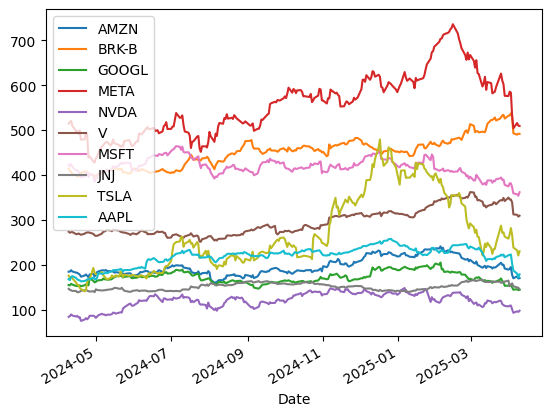

In [1121]:
stock_to_use = 'AAPL'
stocks = ['AAPL', 'AMZN', 'BRK-B', 'GOOGL', 'META', 'NVDA', 'V', 'MSFT', 'JNJ', 'TSLA']

if stock_to_use in stocks:
    stocks.remove(stock_to_use)
else:
    print('ERROR')

stocks.append(stock_to_use)

stock_data = []

for i in stocks:
    stock_data.append(close[i])
    close[i].plot(label=i)

plt.legend()
#stock = close[stock_to_use]
#stock.plot()

In [1122]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 15

X1 = np.array([])
y1 = np.array([])
for i in stock_data:
  X_temp, y_temp = df_to_X_y(i, WINDOW_SIZE)
  X1 = list(X1) + list(X_temp)
  y1 = np.concatenate((y1, y_temp))

#X1, y1 = df_to_X_y(stock, WINDOW_SIZE) ((247, 5, 1), (247,))
X1 = np.array(X1)
y1 = np.array(y1)
X1.shape, y1.shape

observations_in_one_stock = int(X1.shape[0]/len(stocks))
observations_in_one_stock



237

In [1123]:
X_train1, y_train1 = X1[:1500], y1[:1500]
X_val1, y_val1 = X1[1500:-observations_in_one_stock], y1[1500:-observations_in_one_stock]
X_test1, y_test1 = X1[-observations_in_one_stock:], y1[-observations_in_one_stock:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1500, 15, 1), (1500,), (633, 15, 1), (633,), (237, 15, 1), (237,))

In [1124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [1125]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [1126]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 109410.9453 - root_mean_squared_error: 330.7315 - val_loss: 51323.3281 - val_root_mean_squared_error: 226.5465
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63377.4336 - root_mean_squared_error: 251.4728 - val_loss: 13237.5566 - val_root_mean_squared_error: 115.0546
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24243.1250 - root_mean_squared_error: 155.6583 - val_loss: 4515.0977 - val_root_mean_squared_error: 67.1945
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8991.1943 - root_mean_squared_error: 94.4681 - val_loss: 200.5585 - val_root_mean_squared_error: 14.1619
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1723.8927 - root_mean_squared_error: 41.4443 - val_loss: 106.3500 - val_root_mean_squared_error: 10.3126
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 739.9257 - root_mean_squared_error: 27.0844 - val_loss: 100.3286 - val_root_mean_squared_error: 10.0164
Epoch 7/1

In [1127]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'model1/best_model.keras'
cp1 = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [1128]:
train_predictions = model1.predict(X_test1).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test1})
train_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Test Predictions,Actuals
0,168.453049,169.529495
1,166.561661,168.504349
2,165.509415,172.216827
3,167.820847,182.518173
4,176.022827,180.856018
...,...,...
232,222.526077,203.190002
233,201.216293,188.380005
234,182.815628,181.460007
235,176.549271,172.419998


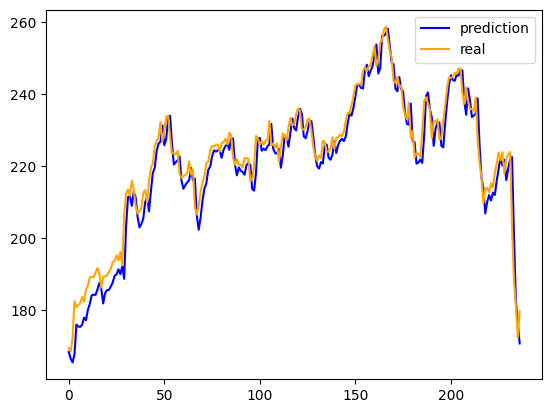

In [1129]:
import matplotlib.pyplot as plt
plt.plot(train_results['Test Predictions'][:], color='blue', label='prediction')
plt.plot(train_results['Actuals'][:], color='orange', label='real')
plt.legend()
plt.show()


21.56722152996161


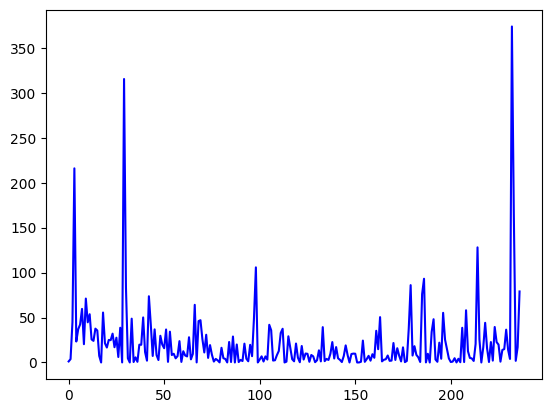

In [1130]:
plt.plot(np.abs(train_results['Test Predictions'][:]-train_results['Actuals'][:])**2, color='blue', label='prediction')
print(np.mean(np.abs(train_results['Test Predictions'][:]-train_results['Actuals'][:])**2))

In [1131]:
train_results.to_csv('test_results.csv', index=False)

# Load CSV into DataFrame
test_data = pd.read_csv('test_results.csv')

# Create a new column showing the difference
test_data['Difference'] = test_data['Test Predictions'] - test_data['Actuals']

# Calculate the difference from today to tomorrow for both columns
test_data['Predictions Difference'] = test_data['Test Predictions'].shift(-1) - test_data['Test Predictions']
test_data['Actuals Difference'] = test_data['Actuals'].shift(-1) - test_data['Actuals']

# Show the first few rows
test_data

,Test Predictions,Actuals,Difference,Predictions Difference,Actuals Difference
0,168.45305,169.529495,-1.076445,-1.89139,-1.025146
1,166.56166,168.504349,-1.942689,-1.05225,3.712479
2,165.50941,172.216827,-6.707417,2.31144,10.301346
3,167.82085,182.518173,-14.697323,8.20198,-1.662155
4,176.02283,180.856018,-4.833188,-0.55611,0.686768
...,...,...,...,...,...
232,222.52608,203.190002,19.336078,-21.30978,-14.809998
233,201.21630,188.380005,12.836295,-18.40067,-6.919998
234,182.81563,181.460007,1.355623,-6.26636,-9.040009
235,176.54927,172.419998,4.129272,-5.74803,7.270004


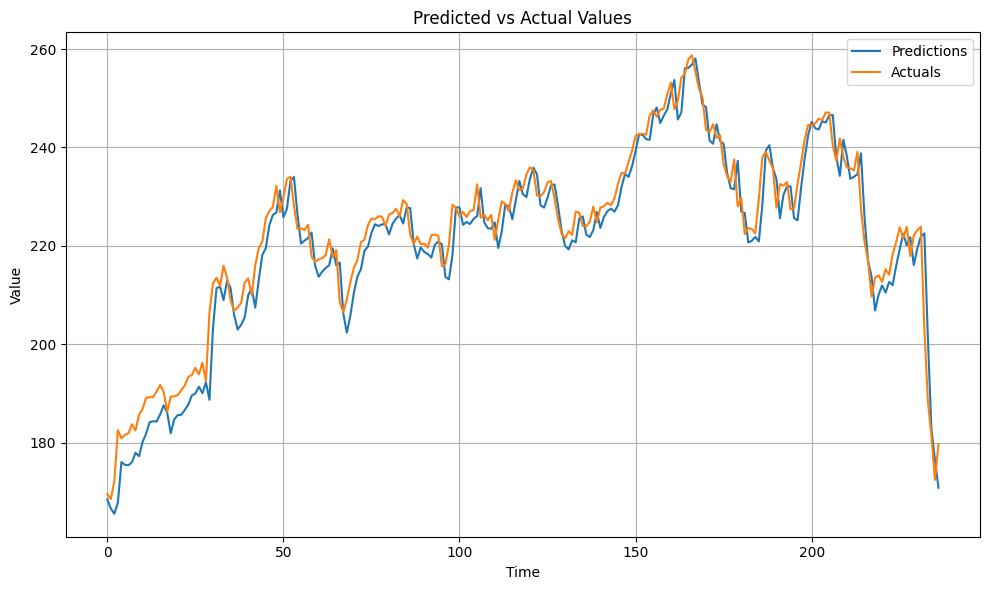

In [1132]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_data['Test Predictions'], label='Predictions')
plt.plot(test_data['Actuals'], label='Actuals')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

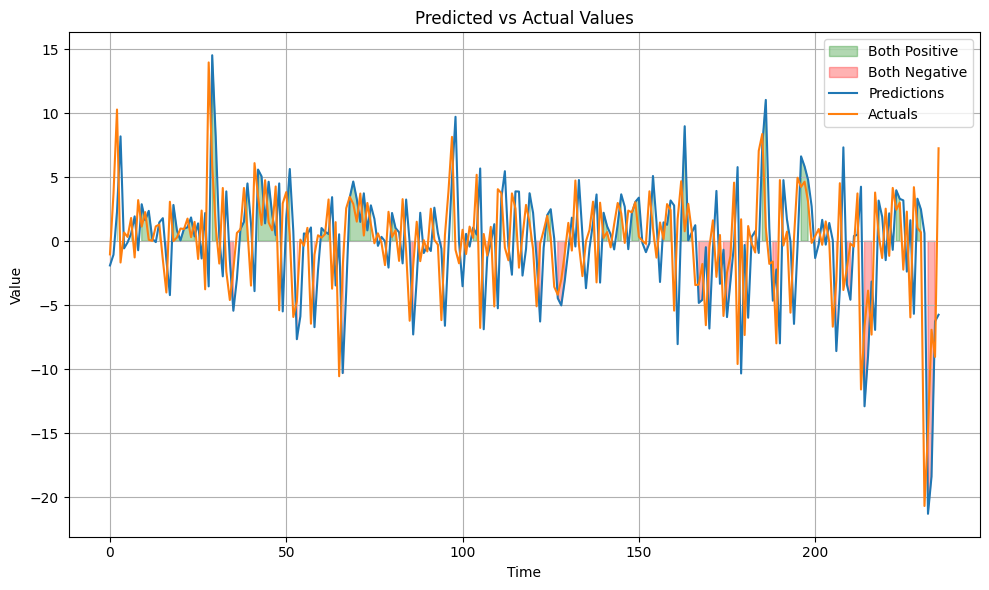

In [1133]:
# Plotting
plt.figure(figsize=(10, 6))

# Highlighting where both predictions and actuals are positive
plt.fill_between(range(len(test_data['Predictions Difference'])), 0, test_data['Predictions Difference'], where=(test_data['Predictions Difference'] > 0) & (test_data['Actuals Difference'] > 0), color='green', alpha=0.3, label='Both Positive')

# Highlighting where both predictions and actuals are negative
plt.fill_between(range(len(test_data['Predictions Difference'])), 0, test_data['Predictions Difference'], where=(test_data['Predictions Difference'] < 0) & (test_data['Actuals Difference'] < 0), color='red', alpha=0.3, label='Both Negative')

plt.plot(test_data['Predictions Difference'], label='Predictions')
plt.plot(test_data['Actuals Difference'], label='Actuals')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1134]:
start_money = 100
current_money = start_money
current_stocks = 0

pred_dif = test_data['Predictions Difference']
actuals = test_data['Actuals']
own_stock = False


for day in range(observations_in_one_stock-1):
    if pred_dif[day] < 0 and own_stock:
        
        if current_money != 0:
            print('ERROR 1')
            
        current_money = current_stocks * actuals[day]
        current_stocks = 0
        own_stock = False
        
    elif pred_dif[day] > 0 and not own_stock:
        #Buy
        if current_stocks != 0:
            print('ERROR 2')
            
        current_stocks = current_money/actuals[day]
        current_money = 0
        own_stock = True

if own_stock:
    current_money = current_stocks * actuals[day]
    current_stocks = 0
    own_stock = False
    
print("trading result", current_money)
print("yearly stock change", start_money*(actuals[observations_in_one_stock-1]/actuals[0]))


trading result 103.5132966463129
yearly stock change 105.99335660606366
